In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import os

In [2]:
today = datetime.today().replace(hour=0, minute=0, second=0, microsecond=0)
c_botas_tlmwh_conversion = 94.74943
c_botas_fees_per_sm3 = 0.033
c_turkey_transmission_fee = 18  # TRY iletim bedeli
c_turkey_coal_transportation = 5  # USD
c_pence_therm_to_pound_mwh = 2.93071
c_gas_plant_efficiency = 0.4913
c_coal_to_mwh = 6.978
c_coal_plant_efficiency = 0.38
c_gas_mo_intensity = 0.18404
c_coal_mo_intensity = 0.34056
c_uk_cpf = 18  # 18 pound carbon price floor for UK
c_gas_overhead_eur_mwh = 1.965
c_xa1_overhead_eur_mwh = 4.4
# EUR 3 # GBP 4 # TRY 1

In [3]:
def calculate_spark_spread(
                           contract_curve, gas_curve,
                           emission_curve, contract, gas_overhead):
    spark_cost = (gas_curve / c_gas_plant_efficiency) + gas_overhead
    spark_cost_clean = spark_cost + (
        emission_curve * (c_gas_mo_intensity / c_gas_plant_efficiency))
    if contract == "ELTBM":
        spark_cost = spark_cost + c_turkey_transmission_fee
    spark = contract_curve - spark_cost
    spark_clean = spark - (
        emission_curve * (c_gas_mo_intensity / c_gas_plant_efficiency))
    return spark, spark_clean, spark_cost, spark_cost_clean


def calculate_dark_spread(
                          contract_curve, coal_curve,
                          emission_curve, contract, coal_overhead):
    dark_cost = (coal_curve / c_coal_plant_efficiency) + coal_overhead
    dark_cost_clean = dark_cost + (
        emission_curve * (c_coal_mo_intensity / c_coal_plant_efficiency))
    if contract == "ELTBM":
        dark_cost = dark_cost + c_turkey_transmission_fee
    dark = contract_curve - dark_cost
    dark_clean = dark - (
        emission_curve * (c_coal_mo_intensity / c_coal_plant_efficiency))
    return dark, dark_clean, dark_cost, dark_cost_clean


def calculate_switching_price(coal_curve, emission_curve, gas_overhead, coal_overhead):
    sw = c_gas_plant_efficiency * (
        coal_curve / c_coal_plant_efficiency + coal_overhead +
        ((c_coal_mo_intensity / c_coal_plant_efficiency) -
         (c_gas_mo_intensity / c_gas_plant_efficiency)) *
        emission_curve)
    return sw


def calculate_coal_switching_price(gas_curve, emission_curve, gas_overhead, coal_overhead):
    sw = c_coal_plant_efficiency * (
        gas_curve / c_gas_plant_efficiency + gas_overhead +
        ((c_gas_mo_intensity / c_gas_plant_efficiency) -
         (c_coal_mo_intensity / c_coal_plant_efficiency)) *
        emission_curve)
    return sw

In [11]:
timeseries_path = r"C:/Users/mehmetg/jupyter/Timeseries/Timeseries/"

ttf = pd.read_csv(
    timeseries_path + "TTF-daily-spot.csv",
    parse_dates=True, index_col=0, squeeze=True)

ttfm = pd.read_csv(
    timeseries_path + "TTF-monthly-spot.csv",
    parse_dates=True, index_col=0, squeeze=True)

eua = pd.read_csv(
    timeseries_path + "EUA-daily-settle.csv",
    parse_dates=True, index_col=0, squeeze=True)

In [12]:
api2 = pd.read_csv(
    timeseries_path + "API2-daily-settle.csv",
    parse_dates=True, index_col=0, squeeze=True)
h_api2 = api2.resample("MS").mean()

In [16]:
atw = pd.read_csv(
    r"C:/Users/mehmetg/jupyter/Timeseries/"
    "Timeseries/ATW-monthly-settle.csv", index_col=0, header=0, parse_dates=True, squeeze=True)
xa1 = pd.read_csv(
    r"C:/Users/mehmetg/jupyter/Timeseries/"
    "Timeseries/API2-daily-settle.csv", index_col=0, header=0, parse_dates=True, squeeze=True)
xa1 = xa1.resample("MS").mean()
coal = pd.concat([xa1, atw])
coal = coal.groupby(coal.index).last()

In [17]:
coal = coal.resample("MS").mean()

In [19]:
eurusd = pd.read_csv(r"C:/Users/mehmetg/jupyter/Data/FX/Historical/EURUSD.csv", index_col=0, parse_dates=True)

In [20]:
eurusd = eurusd['Close']

In [21]:
eurusd = eurusd.groupby(eurusd.index).first()

In [22]:
coal_eurmwh = coal / eurusd.reindex(coal.index).fillna(1.20) / c_coal_to_mwh

In [23]:
ttfm = ttfm.iloc[:-2]
ttf = ttf.resample("MS").mean()[ttfm.index[-1]:].iloc[1:]

In [24]:
h_ttf = pd.concat([ttfm, ttf])
h_eua = eua.resample("MS").mean()

In [27]:
ice_path = r"C:/Users/mehmetg/jupyter/Data/ICE/"

In [28]:
ttf_files = os.listdir(ice_path + "TTF")
ttf_files = [f for f in ttf_files if "intraday" not in f]
ttf_files = [f for f in ttf_files if "historical" in f]
ttf_files = [f for f in ttf_files if "Cal" not in f]
ttf_files = [f for f in ttf_files if "Summer" not in f]
ttf_files = [f for f in ttf_files if "Winter" not in f]
ttf_files = [f for f in ttf_files if "Q" not in f]

f_ttf = {}
for file in ttf_files:
    strip = datetime.strptime(file.split("-")[0], "%b%y")
    settle = pd.read_csv(ice_path + "TTF/" + file, parse_dates=True, index_col=0)['Price']
    f_ttf[strip] = settle.dropna().iloc[-1]
f_ttf = pd.Series(f_ttf).sort_index()
t_ttf = f_ttf[today:]

In [29]:
eua_files = os.listdir(ice_path + "EUA")
eua_files = [f for f in eua_files if "intraday" not in f]
eua_files = [f for f in eua_files if "historical" in f]
eua_files = [f for f in eua_files if "Cal" not in f]
eua_files = [f for f in eua_files if "Summer" not in f]
eua_files = [f for f in eua_files if "Winter" not in f]
eua_files = [f for f in eua_files if "Q" not in f]

f_eua = {}
for file in eua_files:
    strip = datetime.strptime(file.split("-")[0], "%b%y")
    settle = pd.read_csv(ice_path + "EUA/" + file, parse_dates=True, index_col=0)['Price']
    f_eua[strip] = settle.dropna().iloc[-1]
f_eua = pd.Series(f_eua).sort_index()
f_eua = f_eua[today:]

In [30]:
curve_ttf = pd.concat([h_ttf, f_ttf]).sort_index()
curve_eua = pd.concat([h_eua, f_eua]).sort_index()
curve_coal = coal_eurmwh

start_dt = max(curve_ttf.index[0], curve_eua.index[0], curve_coal.index[0])
end_dt = min(curve_ttf.index[-1], curve_eua.index[-1], curve_coal.index[-1])

curve_ttf = curve_ttf[start_dt:end_dt].resample("MS").mean().interpolate()
curve_eua = curve_eua[start_dt:end_dt].resample("MS").mean().interpolate()
curve_coal = curve_coal[start_dt:end_dt].resample("MS").mean().interpolate()

In [31]:
curve_ttf = curve_ttf[:"2024-12-31"]
curve_eua = curve_eua[:"2024-12-31"]
curve_coal = curve_coal[:"2024-12-31"]

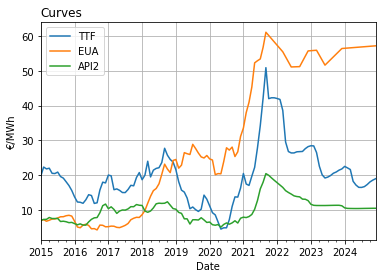

In [32]:
curve_ttf.plot(label="TTF")
curve_eua.plot(label="EUA")
curve_coal.plot(label="API2")
plt.title("Curves", loc="left")
plt.legend(loc=0)
plt.ylabel("€/MWh")
plt.grid()
plt.show()

In [33]:
dark_cost = (curve_coal / c_coal_plant_efficiency) + c_xa1_overhead_eur_mwh
spark_cost = (curve_ttf / c_gas_plant_efficiency) + c_gas_overhead_eur_mwh


In [34]:
dark_cleaning = curve_eua * (c_coal_mo_intensity / c_coal_plant_efficiency)
spark_cleaning = curve_eua * (c_gas_mo_intensity / c_gas_plant_efficiency)

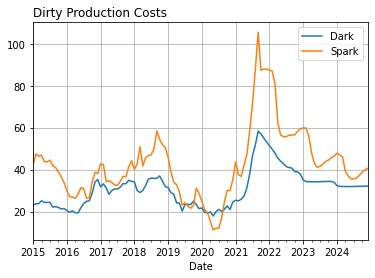

In [35]:
dark_cost.plot(label="Dark")
spark_cost.plot(label="Spark")
plt.legend(loc=0)
plt.title("Dirty Production Costs", loc="left")
plt.grid()
plt.show()

In [36]:
breakeven_eua = (dark_cost - spark_cost) / ((c_gas_mo_intensity / c_gas_plant_efficiency) - (c_coal_mo_intensity / c_coal_plant_efficiency))

In [39]:
breakeven_eua[:"2022-06-01"].max()

90.54757967937984

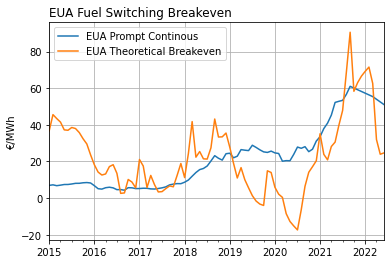

In [40]:
curve_eua[:"2022-06-01"].plot(label="EUA Prompt Continous")
breakeven_eua[:"2022-06-01"].plot(label="EUA Theoretical Breakeven")
plt.legend(loc=0)
plt.title("EUA Fuel Switching Breakeven", loc="left")
plt.xlabel("")
plt.ylabel("€/MWh")
plt.grid()
plt.show()

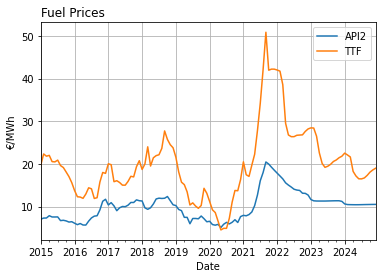

In [41]:
curve_coal.plot(label="API2")
curve_ttf.plot(label="TTF")
plt.legend(loc=0)
plt.ylabel("€/MWh")
plt.grid()
plt.title("Fuel Prices", loc="left")
plt.show()

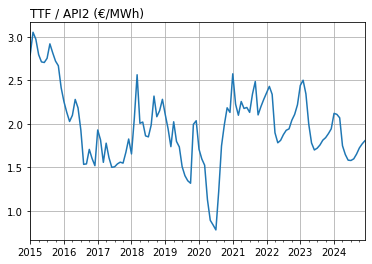

In [42]:
(curve_ttf / curve_coal).plot()
plt.title("TTF / API2 (€/MWh)", loc="left")
plt.grid()
plt.show()

In [43]:
be_dark_cleaning = breakeven_eua * (c_coal_mo_intensity / c_coal_plant_efficiency)
be_spark_cleaning = breakeven_eua * (c_gas_mo_intensity / c_gas_plant_efficiency)

In [44]:
be_eua_ys = breakeven_eua.resample("YS").mean()

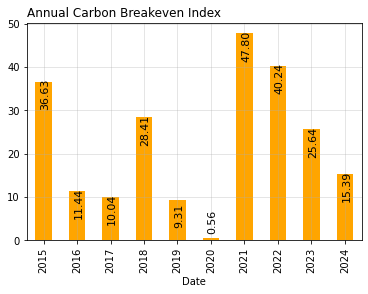

In [45]:
be_eua_ys.plot(kind="bar", color="orange")
for key, val in be_eua_ys.iteritems():
    plt.text(
        key.year-2015+0.05, max(val-6,2), "{:.2f}".format(val), rotation=90, horizontalalignment="center",
        fontsize=11)
plt.grid(True, alpha=0.4)
plt.title("Annual Carbon Breakeven Index", loc="left")
plt.xticks(range(len(be_eua_ys)),be_eua_ys.index.year)
plt.show()

In [46]:
eua_be_ratio = curve_eua / breakeven_eua

In [47]:
breakeven_eua_matrix = breakeven_eua.groupby([breakeven_eua.index.month, breakeven_eua.index.year]).mean().unstack()

In [48]:
ebrm = eua_be_ratio.groupby([eua_be_ratio.index.month, eua_be_ratio.index.year]).mean().unstack()

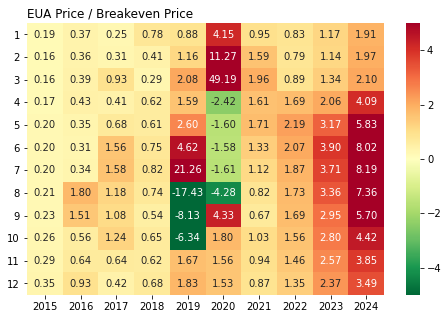

In [49]:
plt.figure(figsize=(8,5))
sns.heatmap(ebrm, annot=ebrm, fmt=".2f", vmax=5, vmin=-5, cmap="RdYlGn_r", center=0)
plt.yticks(rotation=0)
plt.title("EUA Price / Breakeven Price", loc="left")
plt.show()

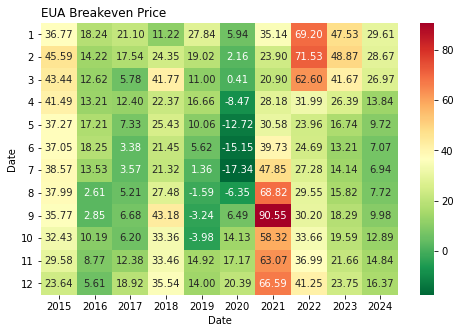

In [50]:
plt.figure(figsize=(8,5))
sns.heatmap(breakeven_eua_matrix, annot=breakeven_eua_matrix, fmt=".2f", cmap="RdYlGn_r")
plt.yticks(rotation=0)
plt.title("EUA Breakeven Price", loc="left")
plt.show()